In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from os import listdir
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 7,
                     'axes.labelpad': 5,
                     'axes.labelsize': 8,
                     'xtick.labelsize' : 7,
                     'ytick.labelsize' : 7,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 0.5,
                     'lines.markersize': 2,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 80.0,
                     'figure.figsize': [5, 3],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 2,
                     'xtick.minor.size': 1,
                     'ytick.major.size': 2,
                     'ytick.minor.size': 1,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.2,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.2})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "20 wt.% PEI"
SAMPLE_SHORT = SAMPLE[:2]
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[1, 0, 1, 0],
     [1, 0, 1, 0],
     [0, 1, 0, 1, 0]]
# ignore these runs: unusable / redundant data
id_out = ["50-0"]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[0, 6989, 16205, 25988],
             [1.8848e+04, 19289, 25645, 33843],
             [7.0136e+03, 10697, 18196, 25623, 32600]]
# columns (indices) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_col, er_col, ei_col, t_col = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI20/"
files = ["13-10_M2_TBD031_PEI20_70C_CNCN.TXT",
         "13-13_M1_TBD031_PEI20_50C_NdryCNCN.TXT",
         "13-14_M2_TBD031_PEI20_30C_NdryCNCN.TXT"]
DATA = [[], [], []]

for m, f in enumerate(files) :
     # import ascii data, usually it has a header of 4 lines that is cut out
     data_ = np.genfromtxt(folder+f, delimiter='\t', skip_header=4)

     # remove points before start of first run
     after = data_[:,-1] >= GASCHANGE[m][0]
     data = data_[after]

     # add final time to GASCHANGE, needed in main and make time unit hours
     GASCHANGE[m].append(data[-1,-1])
     GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
     data[:,-1] = data[:,-1] / 60.

     DATA[m] = data

In [3]:
### Data processing

def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # returns matrix of shape (m-1,n)
    return (y[1:, :] - y[:-1, :]) / (x[1:] - x[:-1])[:, np.newaxis]
    

f_out = [5e5] # ignore data of these frequencies
def extract_interpolate_and_derivative(data, num_points=0):
    """
    Extracts lists x_k for every measured data x at a fixed frequency k
    Creates a universal test set of time points
    Interpolates every fixed-frequency data set for those time points
    Computes derivative epsilon'_der along frequency axis
    """
    
    # Extract unique F_k values
    # ignore frequencies specified in f_out
    unique_f = np.unique(data[:, f_col])
    mask = ~np.isin(unique_f, f_out)
    unique_f = unique_f[mask]
    lnw = np.log(2*np.pi*unique_f)  # Compute ln(omega)
    
    # find time boundaries of data
    # and generate `num_points` equidistant t_i values
    initial_test_t, final_test_t = -np.inf, np.inf
    for f_k in unique_f :
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        initial_test_t = max(initial_test_t, np.min(t_k))
        final_test_t = min(final_test_t, np.max(t_k))
    if not num_points:
        num_points = int((final_test_t - initial_test_t) *2)
        
    t_test_set = np.linspace(initial_test_t, final_test_t, num_points)

    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_int, ei_int = [], []
    # Group er_k and ei_k based on unique F_k
    # unify to test times by interpolation
    for f_k in unique_f:
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        er_k = data[mask][:, er_col]
        ei_k = data[mask][:, ei_col]
        
        interpolator_er_k = interp1d(t_k, er_k, kind='linear', bounds_error=False, fill_value=np.nan)
        interpolator_ei_k = interp1d(t_k, ei_k, kind='linear', bounds_error=False, fill_value=np.nan)

        er_int.append(interpolator_er_k(t_test_set))
        ei_int.append(interpolator_ei_k(t_test_set))

    er_int = np.array(er_int)
    ei_int = np.array(ei_int)


    # Compute gradient of er_k along ln(F)
    er_der =  -np.pi/2 * gradient_matrix(er_int, lnw)
    #er_der =  -np.pi/2 * np.gradient(er_int, lnw, axis=0)

    return unique_f, er_der.T, ei_int.T, t_test_set


def score(popt, pcov, y_data, f_data):
    """
    Computes a fit quality score based on R^2, reduced chi-square, AIC, BIC, and parameter covariances.

    Parameters:
        popt (np.ndarray): Optimized fit parameters from curve_fit.
        pcov (np.ndarray): Covariance matrix of fit parameters from curve_fit.
        y_data (np.ndarray): Measured values.
        f_data (np.ndarray): Fitted values.

    Returns:
        float: Fit quality score (higher is better).
    """
    N = len(y_data)  # Number of data points
    p = len(popt)    # Number of fit parameters
    dof = max(N - p, 1)  # Degrees of freedom (avoid division by zero)

    # Residuals
    residuals = y_data - f_data
    RSS = np.sum(residuals**2)  # Residual sum of squares
    TSS = np.sum((y_data - np.mean(y_data))**2)  # Total sum of squares

    # Coefficient of determination (R^2)
    r_squared = 1 - (RSS / TSS) if TSS > 0 else 0

    # Reduced chi-square (if assuming equal variance in y)
    chi_sq_red = RSS / dof

    # Akaike Information Criterion (AIC)
    aic = 2 * p + N * np.log(RSS / N)

    # Bayesian Information Criterion (BIC)
    bic = p * np.log(N) + N * np.log(RSS / N)

    # Covariance penalty: Large covariance values indicate poorly constrained parameters
    cov_trace = np.trace(pcov) if pcov is not None else 0
    cov_score = np.exp(-np.abs(cov_trace))  # Penalizes large uncertainties

    # Normalize scores
    chi_sq_score = np.exp(-abs(chi_sq_red - 1.0))  # Peaks at chi_sq_red ≈ 1
    aic_bic_score = np.exp(-0.1 * (aic + bic) / 2)  # Penalizes high values

    # Weighted sum (adjust weights if needed)
    score = (0.5 * r_squared) + (0.3 * chi_sq_score) + (0.1 * aic_bic_score) + (0.1 * cov_score)

    return score


In [4]:
### Specify fit function, boundaries and starting initial values; here: CC + CC + CC
# edit this section to change fit function

# base Cole/Cole function for imaginary part
def CC_I(w, de, a, wp) :
    den = 1 + (1j * w/wp)**a
    return -np.imag(de/den)

#base Cole/Cole function for derivative of real part
def CC_R(w, de, a, wp) :
    A = a*np.pi/2
    W = (w/wp)**a
    return np.pi/2 * a*de*W * np.cos(A - 2* np.arctan(np.sin(A)/(1/W+np.cos(A))) ) / (1 + 2*W*np.cos(A) + W**2)

p_labels = ["$\\Delta\\epsilon_2$", "$\\alpha_2$", "$\\omega_{p2}$ [Hz]", 
            "$\\Delta\\epsilon_3$", "$\\alpha_3$", "$\\omega_{p3}$ [Hz]",
            "$\\Delta\\epsilon_1$", "$\\alpha_1$", "$\\omega_{p1}$ [Hz]"]

# starting initial guess for every run
p0_start = [
    # 70 (C-N-C-N)
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    # 50 (N-C-N)
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    [0.7483, 1., 1e3, 0.1884, 0.3615, 10000.0, 13990000.0, 1.0, 3.643e-08],
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    # 30 (N-C-N-C-N)
    [0.0934, 0.7863, 1841.0, 0.1127, 0.5849, 186300.0, 16.14, 0.5487, 0.007909],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06]]

# boundaries
i_ = np.inf
wi1, wf1 = 1e-2, 2e3
wi2, wf2 = 1., 1e7
wi3, wf3 = 0., 3e-1
bounds = ([0., 0., wi1, 0., 0., wi2, 0., 0., wi3], [i_, 1., wf1, i_, 1., wf2, i_, 1., wf3])

# fit functions with three cole-cole terms
def der_real (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log( CC_R(w, de, a, wp) + CC_R(w, de_2, a_2, wp_2) + CC_R(w, de_3, a_3, wp_3) )

def imag (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log ( CC_I(w, de, a, wp) + CC_I(w, de_2, a_2, wp_2) + CC_I(w, de_3, a_3, wp_3) )

def combined_fit(x_all, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3):
    x, mask = x_all  # Unpack the concatenated x values and mask
    y_fit = np.where(mask == 0,   # Apply f1 where mask=0, f2 where mask=1
            der_real(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3), 
            imag(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3))
    return y_fit

# plot single terms
def plot_parts(ax1, w_, *popt) :
    x1_ = CC_R(w_, *popt[:3])
    x2_ = CC_R(w_, *popt[3:6])
    x3_ = CC_R(w_, *popt[6:])
    ax1.plot(w_, x1_, linestyle=':', color='red')
    ax1.plot(w_, x2_, linestyle=':', color='blue')
    ax1.plot(w_, x3_, linestyle=':', color='black')


In [5]:
### fitting and plotting procedure

# indices of fit parameter omega, used in "fixorder" to make sure the three terms go from low to high frequency
peak_indices = [2, 5, 8]
def fixorder(p) :
    # fix order of parameters such that peaks are in ascending order
    # old function that might be useful, needs some work
    peaks = p[peak_indices]
    bigger_than_next = peaks[:-1] > peaks[1:]
    while np.any(bigger_than_next) :
        for i, cell in enumerate(bigger_than_next) :
            if cell :
                temp_ = p[i*3:i*3+3]
                p[i*3:i*3+3] = p[i*3+3:i*3+6]
                p[i*3+3:i*3+6] = temp_

                peaks = p[peak_indices]
                bigger_than_next = peaks[:-1] > peaks[1:]
                break
    return p
    

lnw_area = np.linspace(np.log(1.), np.log(6e4), 100)

def fit(x1, y1, x2, y2, p0, run_num) :
    # if the fit didn't converge or receives a bad "score" (see above), 
    # it will retry with the starting initial guess for the current run
    # starting guesses are specified above

    fitf = combined_fit

    # Combine x and y values into a single array (respectively) and create a mask
    x_all = np.concatenate([x1, x2])  # Flatten xdata
    y_all = np.concatenate([y1, y2])
    mask = np.concatenate([np.zeros_like(x1), np.ones_like(x2)])
    

    try :
        popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds, nan_policy='omit')
        fitscore = score(popt, pcov, y_all, fitf((x_all, mask), *popt))

        if fitscore < 50000 :
            try :
                popt2, pcov2 = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
                fitscore2 = score(popt2, pcov2, y_all, fitf((x_all, mask), *popt2))
            except :
                fitscore2 = 0

            if fitscore < fitscore2 :
                popt = popt2
                fitscore = fitscore2
                print("FALLBACK 1: ", np.round(fitscore2,0))

        mask_area = np.zeros_like(lnw_area)
        y = np.exp(fitf((lnw_area, mask_area), *popt))
        a = np.trapezoid(y, np.exp(lnw_area))
        return popt, a, np.round(fitscore,0)

    except  :
        try :
            popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
            fitscore3 = score(popt, pcov, y_all, fitf((x_all, mask), *popt))
            print("FALLBACK 2: ", np.round(fitscore3,0))

            mask_area = np.zeros_like(lnw_area)
            y = np.exp(fitf((lnw_area, mask_area), *popt))
            a = np.trapezoid(y, np.exp(lnw_area))
            return popt, a, np.round(fitscore3,0)

        except Exception as err :
            print([float(pi) for pi in np.round(p0_start[run_num],4)])
            print(j, i, str(type(err))[8:-2], ": ", err)
            
    return p0, 0, 0


def round_sig(x, n):
    # round to n significant digits
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))


# for smooth plot of fit function
# dense omega values, equidistant in the log regime
lnw_ = np.linspace(-0.5, 15.5, 100)
w_ = np.exp(lnw_)
f_ = w_/2/np.pi

title_text = "BDS of  "

def plot(w_der, x_der, w, x_i, popt, dt, run, id, fitscore) :
    # whole output routine

    # output optimal fit parameters, starting initial guess of the run and fitscore
    # for trouble shooting and detailed insights
    print("fit score", fitscore)
    #print("in. guess at t=0", [float(pi) for pi in p0_start[run]])
    print("fit parameters", [round_sig(pi, 4) for pi in popt])

    fig, ax1 = plt.subplots()
    yscale = 'log'
    plt.xscale('log')
    ax1.set_yscale(yscale)

    # calculate fitted function and individual terms for the plot
    # "..._" for fit data and without "_" for measurement data
    x_der_ = np.exp(der_real(lnw_, *popt))
    x_i_ = np.exp(imag(lnw_, *popt))

    ax1.scatter(w_der, x_der, label="$\\epsilon'_{der}$")
    ax1.plot(w_, x_der_, color='r')
    plot_parts(ax1, w_, *popt)
    ax1.set_ylim(1/2* np.min(x_der) , 10* np.max(x_der))
    ax1.set_ylabel("$\\epsilon'_{der}$") # = -\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}

    ax2 = ax1.twinx()
    ax2.set_yscale(yscale)
    ax2.scatter(w, x_i, color='r', label="$\\epsilon''$")
    ax2.plot(w_, x_i_, color='g')
    ax2.set_ylim(1/10* np.min(x_i) , 2* np.max(x_i))
    ax2.set_ylabel("$\\epsilon''$", color='r')

    timestr = "t = " + str(np.round(dt,1)) + " min"
    title = title_text + SAMPLE_SHORT +'-'+ id + "  at  " + timestr
    plt.title(title)
    ax1.set_xlabel("AC angular frequency $\omega$ [Hz]")

    ax1.legend()
    ax2.legend(bbox_to_anchor=(1, 0.9))
    #plt.savefig("results20/fits/"+id+".png", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_140134/1474685501.py:29: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)


fit score 207307.0
fit parameters [2.554, 0.6391, 7.598, 0.1643, 0.4518, 240400.0, 1e-10, 1.0, 1e-10]


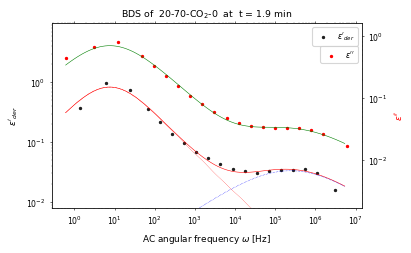

fit score 198841.0
fit parameters [2.55, 0.6493, 7.589, 0.1628, 0.4511, 240400.0, 1e-10, 1.0, 1e-10]


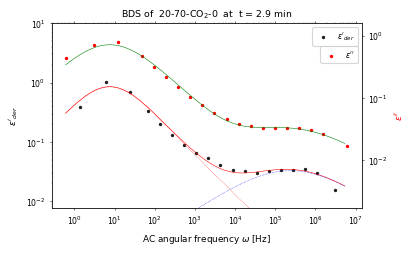

FALLBACK 2:  380761.0
fit score 245675.0
fit parameters [2.566, 0.6509, 5.529, 0.1578, 0.4364, 240400.0, 1e-10, 1.0, 1e-10]


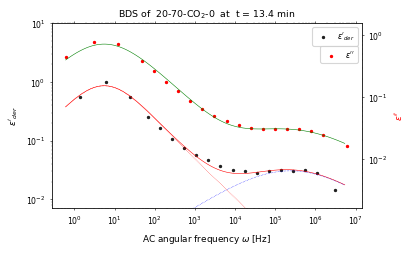

FALLBACK 2:  1637051.0
fit score 1938668.0
fit parameters [2.568, 0.6658, 4.365, 0.1751, 0.3832, 112900.0, 1e-10, 1.0, 1e-10]


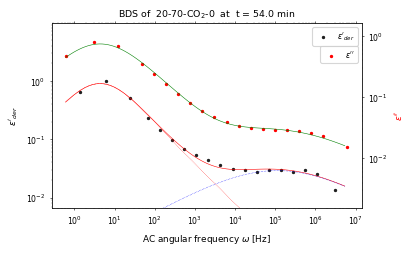

fit score 1900341.0
fit parameters [2.616, 0.6504, 3.636, 0.1643, 0.3934, 112900.0, 1e-10, 1.0, 1e-10]


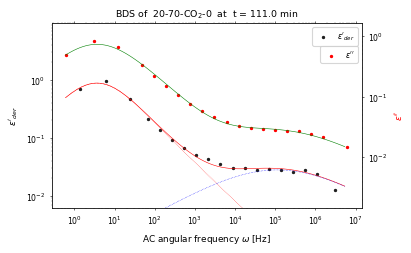

fit score 99436.0
fit parameters [2.341, 0.6243, 12.06, 0.1106, 0.511, 270700.0, 1944000.0, 0.8268, 3.12e-09]


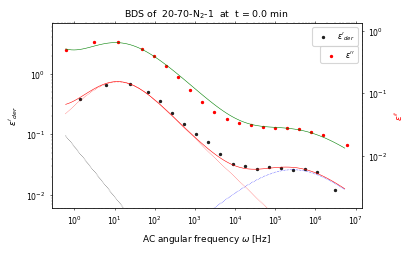

fit score 37672368.0
fit parameters [2.033, 0.7721, 216.8, 0.5638, 0.3093, 5680.0, 2792000.0, 0.8415, 5.36e-08]


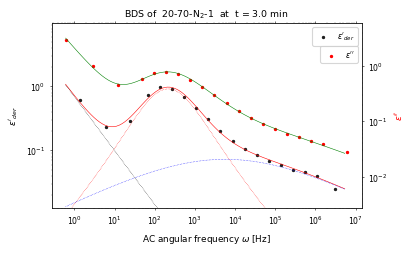

fit score 128949771.0
fit parameters [1.593, 0.7748, 508.3, 1.037, 0.3691, 4874.0, 16970000.0, 0.7967, 1.053e-08]


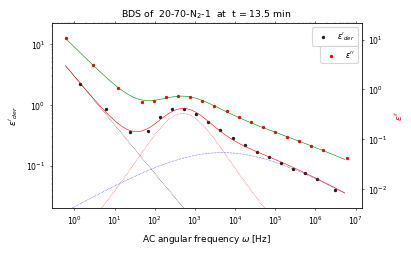

fit score 473365050.0
fit parameters [1.366, 0.7905, 782.3, 1.381, 0.3714, 5824.0, 36340000.0, 0.774, 4.683e-09]


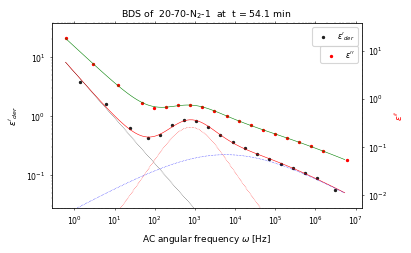

fit score 166484299.0
fit parameters [1.268, 0.797, 835.9, 1.537, 0.3752, 4650.0, 38320000.0, 0.7601, 3.338e-09]


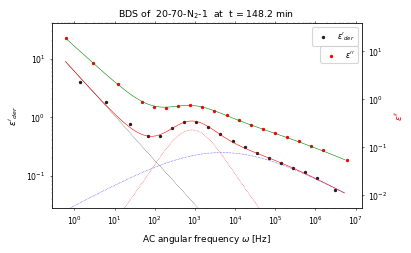

FALLBACK 1:  9.0
FALLBACK 1:  727.0
FALLBACK 2:  43879.0
fit score 43879.0
fit parameters [2.634, 0.6288, 8.664, 0.1559, 0.4855, 240400.0, 1e-10, 1.0, 1e-10]


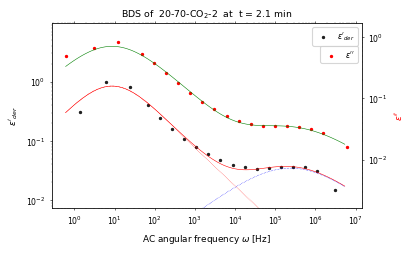

FALLBACK 1:  73631.0
fit score 87475.0
fit parameters [2.663, 0.6389, 7.228, 0.1513, 0.488, 240400.0, 1e-10, 1.0, 1e-10]


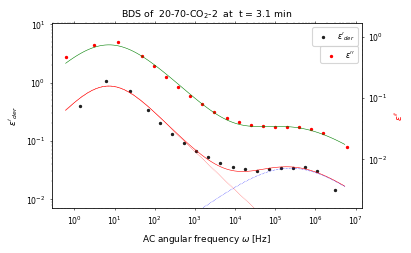

FALLBACK 2:  155834.0
FALLBACK 2:  562970.0
fit score 390962.0
fit parameters [2.608, 0.671, 4.485, 0.1639, 0.4229, 120200.0, 1e-10, 1.0, 1e-10]


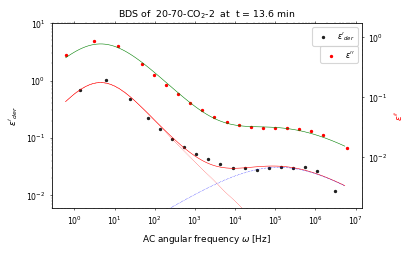

fit score 777054.0
fit parameters [2.668, 0.6464, 3.607, 0.1549, 0.4245, 120200.0, 1e-10, 1.0, 1e-10]


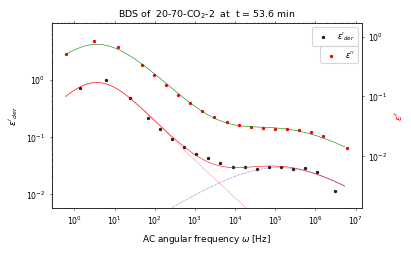

fit score 456177.0
fit parameters [2.762, 0.6267, 2.871, 0.1432, 0.4344, 120200.0, 1e-10, 1.0, 1e-10]


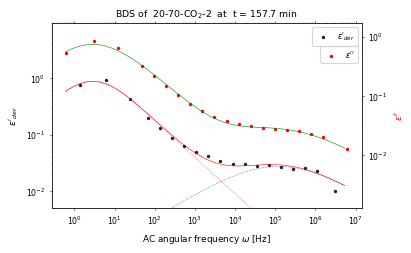

fit score 24144.0
fit parameters [2.307, 0.5151, 23.63, 0.5782, 0.1191, 1657.0, 2270000.0, 0.774, 2.382e-09]


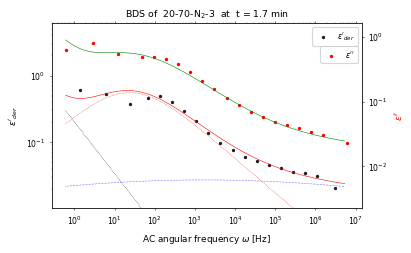

fit score 54453833.0
fit parameters [2.052, 0.7559, 168.9, 0.5752, 0.2867, 3911.0, 3192000.0, 0.8118, 1.772e-08]


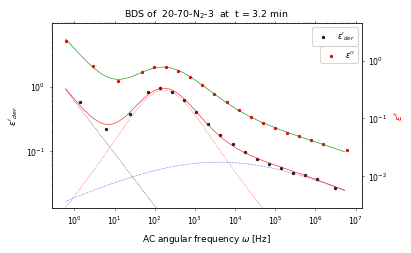

fit score 108075504.0
fit parameters [1.589, 0.7658, 471.7, 1.019, 0.3591, 4490.0, 5089000.0, 0.716, 4.322e-09]


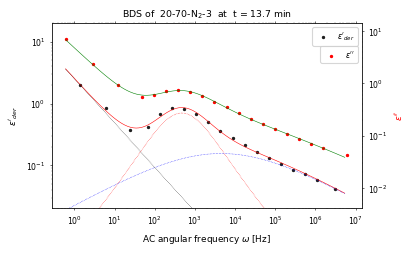

fit score 905845315.0
fit parameters [1.37, 0.7873, 754.8, 1.374, 0.3659, 5715.0, 14420000.0, 0.7354, 4.521e-09]


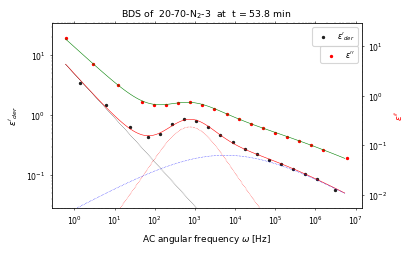

fit score 392782948.0
fit parameters [1.262, 0.8022, 886.3, 1.554, 0.3696, 4737.0, 21290000.0, 0.7415, 4.102e-09]


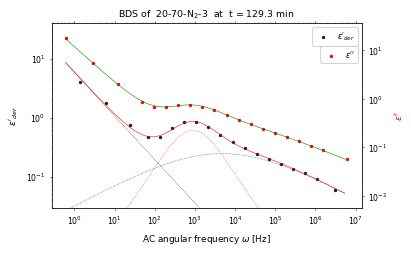

fit score 59681.0
fit parameters [1.952, 0.6177, 8.533, 0.1567, 0.3911, 96900.0, 6903000.0, 1.0, 2.062e-08]


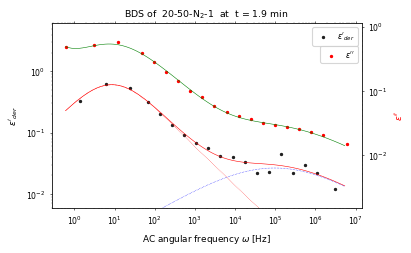

fit score 9835138.0
fit parameters [1.777, 0.6994, 13.15, 0.2622, 0.2969, 12310.0, 3598000.0, 1.0, 5.621e-08]


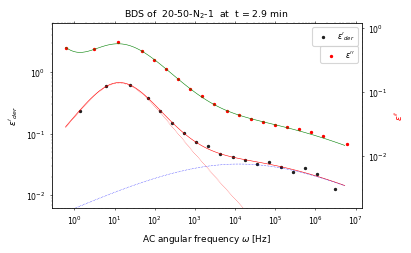

fit score 88254268.0
fit parameters [1.72, 0.7145, 27.1, 0.3513, 0.2598, 5375.0, 46860000.0, 0.982, 5.483e-09]


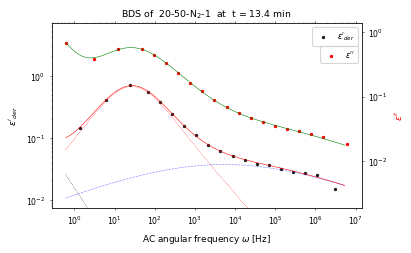

fit score 10420111.0
fit parameters [1.423, 0.7445, 89.1, 0.5949, 0.2729, 1457.0, 111000000.0, 0.8889, 8.556e-10]


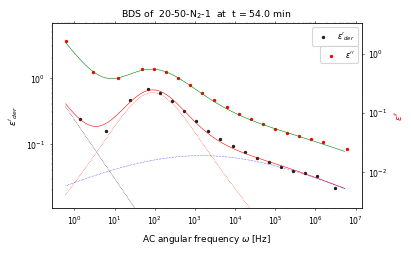

FALLBACK 1:  22452.0
fit score 1446990.0
fit parameters [1.339, 0.75, 115.7, 0.6855, 0.3027, 1827.0, 60830000.0, 0.8602, 1.402e-09]


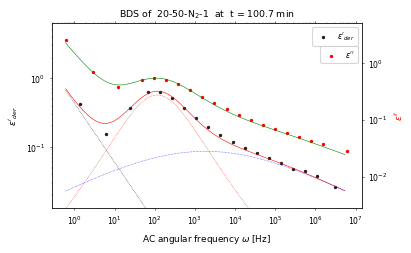

fit score 100417.0
fit parameters [0.5852, 0.7014, 88.7, 0.2669, 0.3193, 5574.0, 23.11, 0.6647, 0.02319]


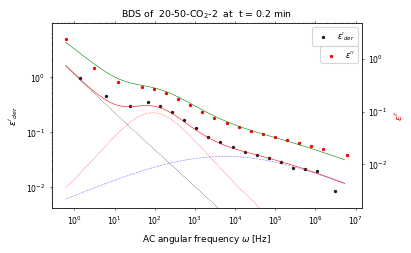

FALLBACK 2:  44194.0
fit score 116584.0
fit parameters [0.0004781, 0.2141, 102.9, 0.1473, 0.3545, 21780.0, 4036.0, 0.4732, 3.194e-08]


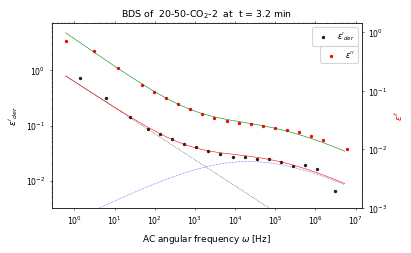

FALLBACK 2:  56955.0
fit score 93148.0
fit parameters [1.915e-05, 0.3008, 259.2, 0.1574, 0.3276, 10540.0, 3839.0, 0.514, 7.983e-08]


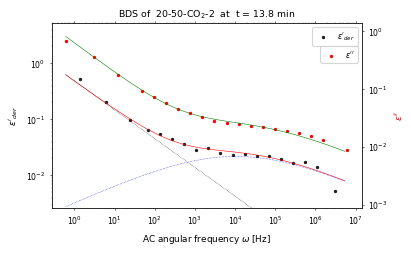

fit score 413267.0
fit parameters [0.1508, 0.3123, 2000.0, 0.02342, 0.715, 264100.0, 8485.0, 0.5395, 3.661e-08]


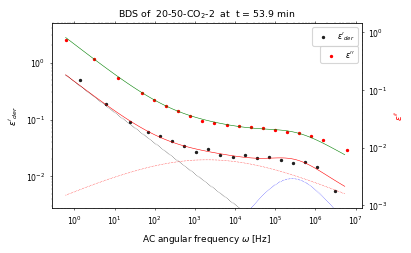

fit score 1021728.0
fit parameters [0.159, 0.305, 1982.0, 0.02122, 0.7498, 298700.0, 20770.0, 0.5531, 1.094e-08]


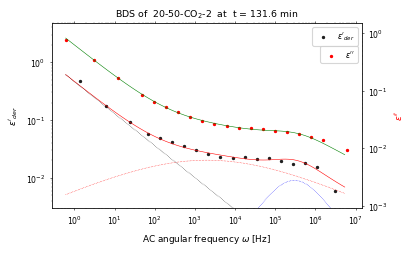

fit score 21016.0
fit parameters [0.8955, 0.7725, 12.17, 0.2402, 0.3221, 3976.0, 36910000.0, 1.0, 1.242e-08]


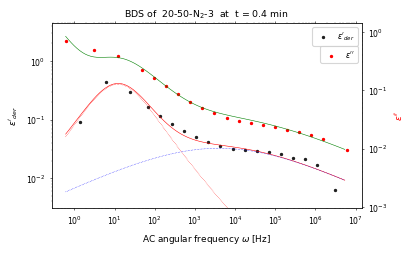

fit score 56682135.0
fit parameters [1.677, 0.7151, 13.05, 0.3061, 0.2668, 5224.0, 3991000.0, 1.0, 5.42e-08]


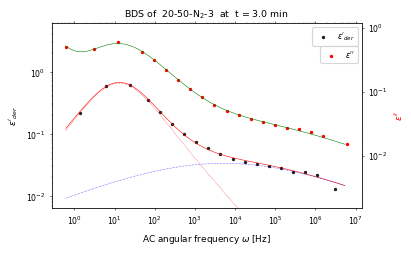

fit score 127991277.0
fit parameters [1.616, 0.7388, 25.04, 0.4215, 0.2355, 1363.0, 2247000.0, 1.0, 1.224e-07]


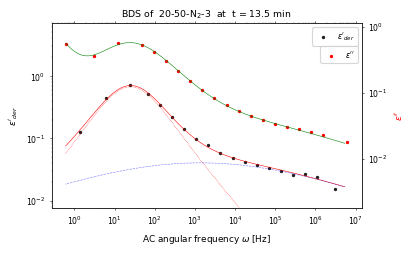

fit score 16149559.0
fit parameters [1.419, 0.7501, 79.37, 0.5928, 0.2654, 1169.0, 30360000.0, 0.8893, 2.929e-09]


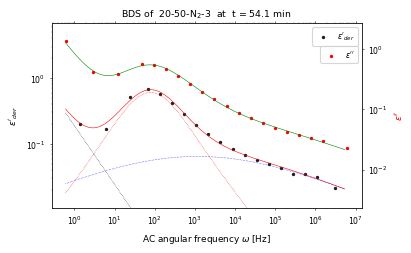

fit score 3946023374.0
fit parameters [1.883, 0.5876, 17.13, 0.4329, 0.3656, 17470.0, 18.48, 0.9999, 0.05571]


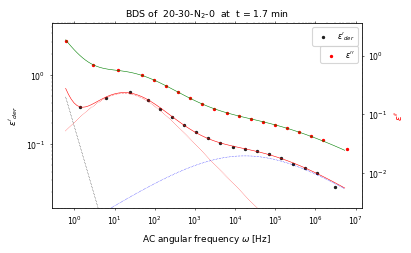

fit score 5607264915.0
fit parameters [1.901, 0.5822, 19.02, 0.4191, 0.3722, 22560.0, 15.9, 1.0, 0.07466]


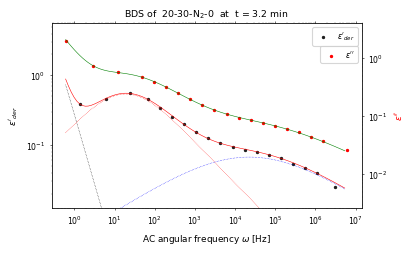

fit score 2976923197.0
fit parameters [1.903, 0.605, 36.56, 0.425, 0.3914, 41180.0, 14.06, 1.0, 0.1794]


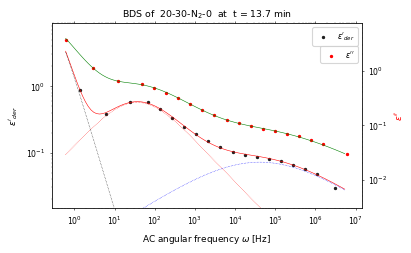

fit score 978665802.0
fit parameters [1.865, 0.6189, 68.47, 0.4046, 0.4106, 85470.0, 64.93, 0.9227, 0.06511]


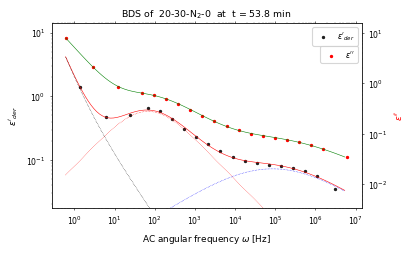

fit score 773303140.0
fit parameters [1.864, 0.6186, 68.92, 0.4033, 0.4104, 86890.0, 66.43, 0.9203, 0.06343]


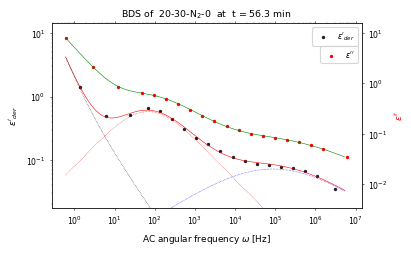

fit score 8007501.0
fit parameters [0.1576, 0.4906, 738.4, 0.0917, 0.6108, 226200.0, 6.546, 0.633, 0.05715]


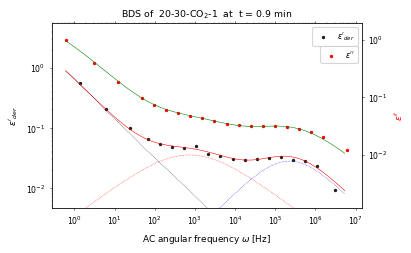

fit score 5027049.0
fit parameters [0.2869, 0.3137, 261.5, 0.0458, 0.741, 282400.0, 7.621, 0.6785, 0.03786]


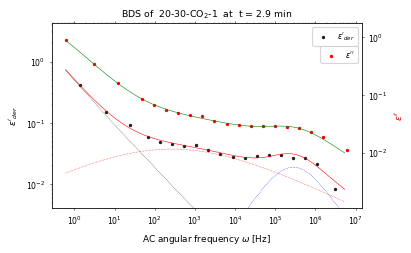

fit score 4553583.0
fit parameters [0.2478, 0.3083, 328.2, 0.03921, 0.7472, 296700.0, 175.0, 0.6637, 0.0002278]


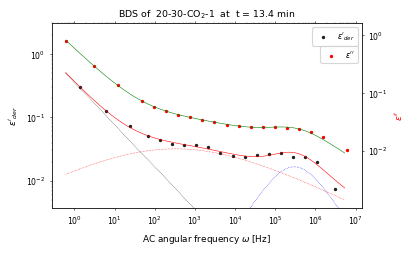

fit score 3504792.0
fit parameters [0.2579, 0.2855, 350.1, 0.0261, 0.8191, 369300.0, 5999.0, 0.7132, 3.054e-06]


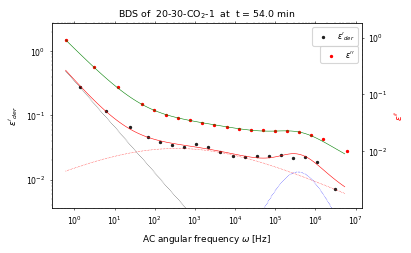

fit score 1756632.0
fit parameters [0.2813, 0.2696, 225.4, 0.02023, 0.8737, 419800.0, 10410.0, 0.7697, 4.35e-06]


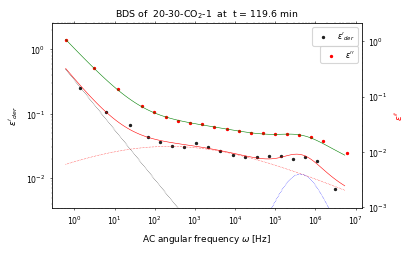

fit score 54399.0
fit parameters [0.4242, 0.745, 7.682, 0.2657, 0.2785, 4002.0, 49850.0, 1.0, 1.399e-05]


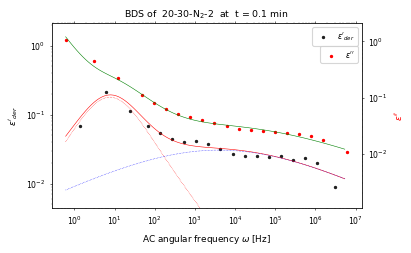

fit score 999439.0
fit parameters [1.95, 0.6247, 1.721, 0.2677, 0.2793, 9527.0, 16030.0, 1.0, 2.562e-05]


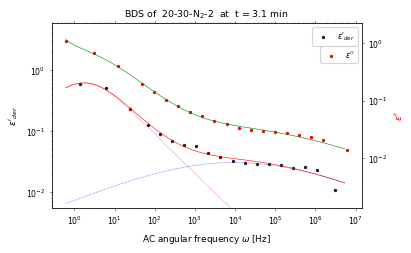

fit score 2271854.0
fit parameters [1.954, 0.6394, 3.066, 0.2498, 0.2973, 17480.0, 13320.0, 1.0, 2.281e-05]


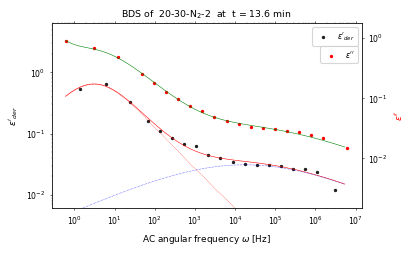

fit score 10058738.0
fit parameters [1.792, 0.6674, 7.218, 0.3121, 0.2629, 11970.0, 19790.0, 1.0, 1.913e-05]


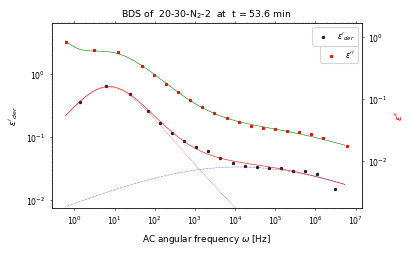

fit score 17744691.0
fit parameters [1.72, 0.6932, 13.44, 0.3807, 0.2431, 7017.0, 78090.0, 1.0, 7.344e-06]


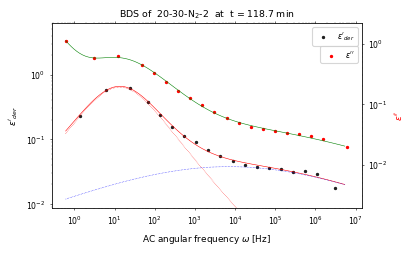

fit score 109900.0
fit parameters [0.0689, 0.6734, 1309.0, 0.08851, 0.538, 176800.0, 21550.0, 0.5833, 5.09e-08]


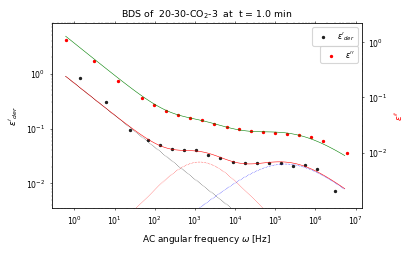

fit score 1947303.0
fit parameters [0.2189, 0.3137, 956.1, 0.02001, 0.8733, 435900.0, 42580.0, 0.6474, 6.217e-08]


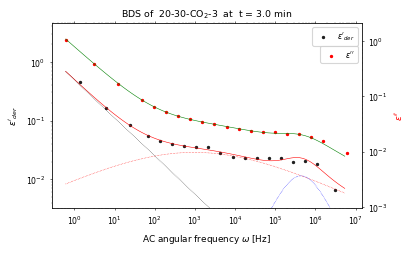

fit score 2085023.0
fit parameters [0.2424, 0.2981, 459.0, 0.02061, 0.8646, 419600.0, 58630.0, 0.6958, 1.003e-07]


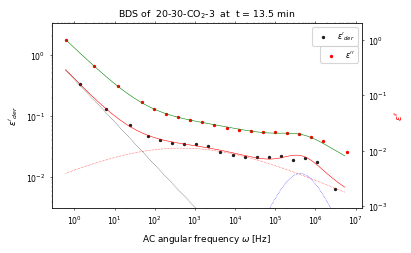

fit score 1158992.0
fit parameters [0.2749, 0.2778, 248.2, 0.01907, 0.8895, 448800.0, 10470.0, 0.7607, 4.194e-06]


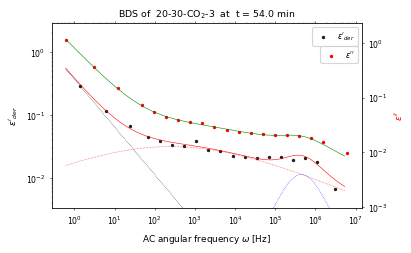

fit score 2796164.0
fit parameters [0.2922, 0.2634, 178.2, 0.01754, 0.901, 459400.0, 15330.0, 0.7878, 4.072e-06]


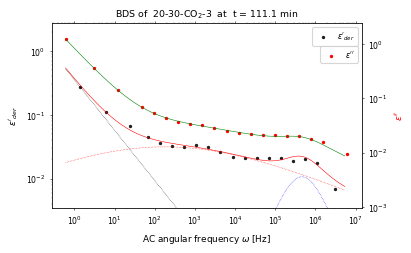

fit score 391562.0
fit parameters [3.004, 0.4191, 0.1621, 0.1172, 0.4319, 131200.0, 32130.0, 1.0, 1.767e-05]


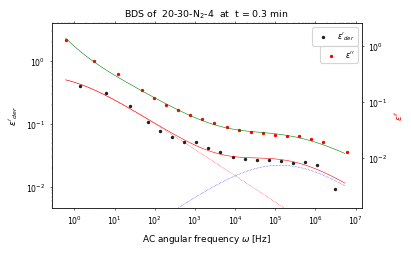

fit score 1275923.0
fit parameters [1.894, 0.6087, 3.392, 0.2519, 0.2916, 17540.0, 26370.0, 1.0, 2.237e-05]


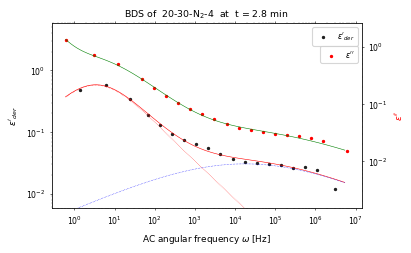

fit score 3548582.0
fit parameters [1.878, 0.6379, 7.497, 0.2726, 0.289, 23110.0, 51450.0, 1.0, 1.284e-05]


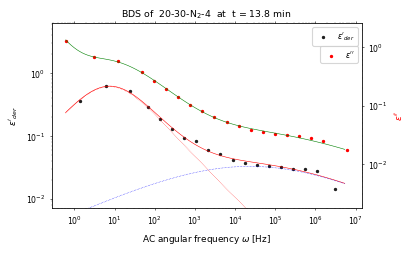

fit score 6456424.0
fit parameters [1.805, 0.6621, 11.27, 0.304, 0.2756, 18470.0, 275900.0, 1.0, 2.382e-06]


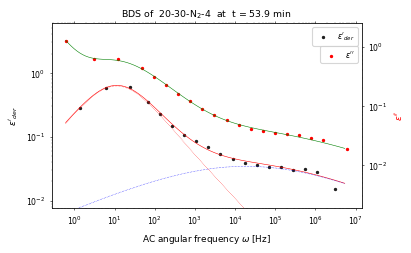

fit score 11039371.0
fit parameters [1.779, 0.676, 14.39, 0.342, 0.2601, 12660.0, 22940000.0, 1.0, 3.307e-08]


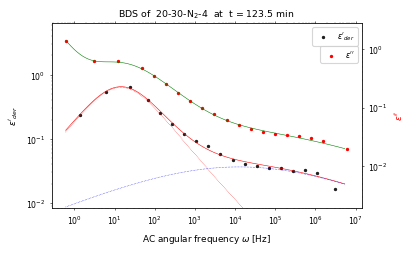

In [6]:
### main

# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,4)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
# ignore last tol minutes of each run to avoid faulty data from next run
tol = 5

# combined lists that save the fit data, will contain numpy arrays of different length, one array per run
P_ALL = []
DT_ALL = []
A_ALL = []
# save ID for easier handling, P_ALL[j] will correspond to ID[j]
# ID is temperature-gas-run ie. "70-N_2-1", as shown in plots
ID = []

# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] / ei[i] (one row of the matrix) is one spectrum
    # where i corresponds to the time
    # ei[:,k] (one column) is the time evolution at a fixed frequency
    # The array contains one whole measurement with fixed temperature and all gas runs
    f, er_der, ei, t = extract_interpolate_and_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    lnw = np.log(w)
    lnw_der = (lnw[:-1] + lnw[1:]) / 2
    w_der = np.exp(lnw_der)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if temp+'-'+str(j) in id_out :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")

        p0 = p0_start[run_num]
        # stack of numpy arrays of all fit parameters of current run: [ [a,b,c,...], [a,b,c,...], ... ]
        PARAMS = []
        # stack of times; needed because fit doesn't always converge. DT[i] corresponds to PARAMS[i]
        DT = []
        A = []

        plot_i = 0
        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0

            # if the fit converged, p0 (next initial guess) will be the optimal parameters   
            p0, a, fitscore = fit(lnw_der, ln_er_der[i], lnw, np.log(ei[i]), p0, run_num)
            #p0 = fixorder(p0)

            if fitscore > 17000 :
                # save fit parameters and time if the fit was successful
                PARAMS.append(p0)
                A.append(a)
                DT.append(dt)

                # plot a small selection of spectra
                if dt > plottimes[plot_i] or i==t1_i-1 :
                    plot(w_der, er_der[i], w, ei[i], p0, dt, run_num, ID[-1], fitscore)
                    plot_i += 1


        # after processing whole run: save all the fit data of the run in big combined list
        # swap axes of PARAMS, such that the colums-rows are times-fit parameters
        P = np.swapaxes(PARAMS, 0, 1)
        P_ALL.append(P)
        DT_ALL.append(np.array(DT))
        A_ALL.append(np.array(A))

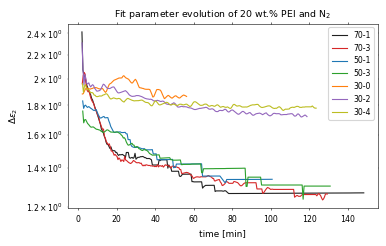

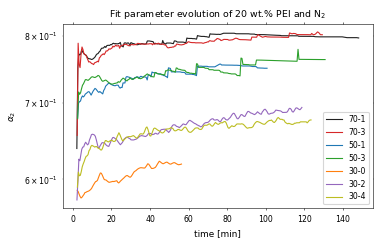

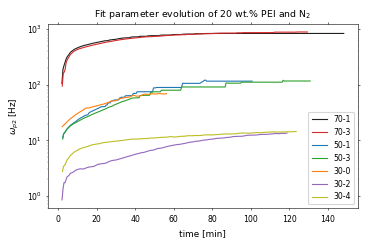

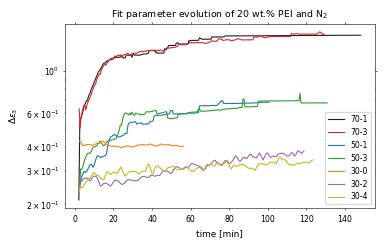

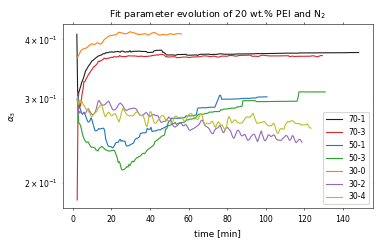

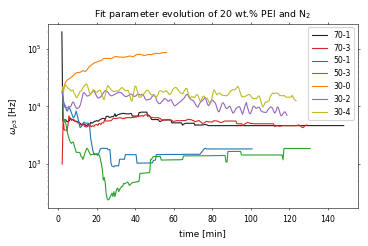

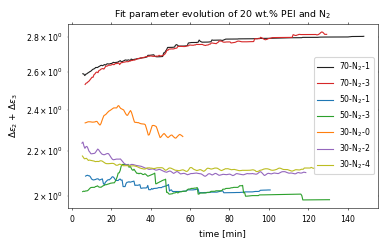

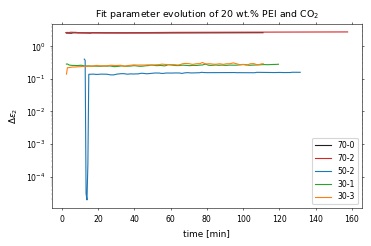

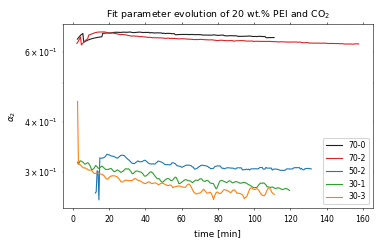

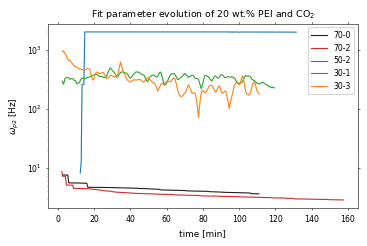

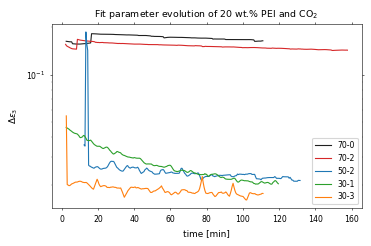

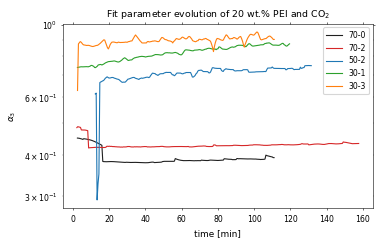

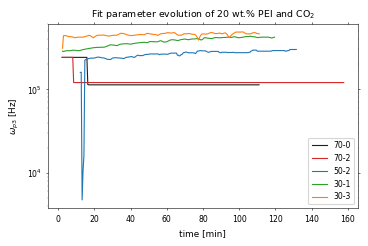

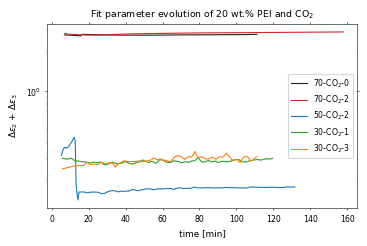

In [7]:
### Plot time evolution of fit parameters

title_text = "Fit parameter evolution of "+ SAMPLE + " and "

good = [DT_ALL[j] > 2 for j in range(len(DT_ALL))]
DT_ALL_ = [DT_ALL[j][good[j]] for j in range(len(DT_ALL))]
P_ALL_ = [P_ALL[j][:, good[j].flatten()] for j in range(len(DT_ALL))]

# j: run with specific temp and gas
# i: parameters

for gas in GASES :
    for i, parameter in enumerate(p_labels[:-3]) :
        plt.xscale('linear')
        plt.yscale('log')

        #l, u = 1e50, -1

        for j, id in enumerate(ID) :
            if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            if id[3] == "C" and id[0] == "5":
                n = 20
            else :
                n = 0
            #if id[0] == "7" and id[-1] == "2" :
            #    continue
            label = id[:2] + id[-2:]

            x, y = DT_ALL_[j][n:], P_ALL_[j][i][n:]
            #lower_threshold, upper_threshold = np.percentile(y, [5, 95])
            #l, u = min(lower_threshold, l), max(upper_threshold, u)

            plt.plot(x, y, label=label, linewidth=1)
            plt.title(title_text + gas)

        plt.xlabel("time [min]")
        plt.ylabel(parameter)
        plt.legend()
        #plt.savefig("results20/paramkin/"+gas+" "+parameter+".png", bbox_inches='tight')
        plt.show()

    plt.xscale('linear')
    plt.yscale('log')

    for j, id in enumerate(ID) :
        if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
            continue
        de_sum = P_ALL[j][0] + P_ALL[j][3]
        plt.plot(DT_ALL[j][10:], de_sum[10:], label=id, linewidth=1)
        plt.title(title_text + gas)

    plt.xlabel("time [min]")
    plt.ylabel(p_labels[0] + " + " + p_labels[3])
    plt.legend()
    plt.show()

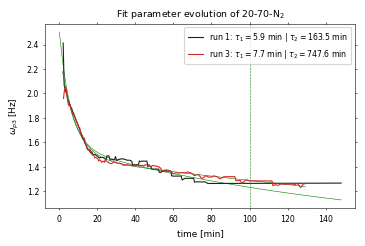

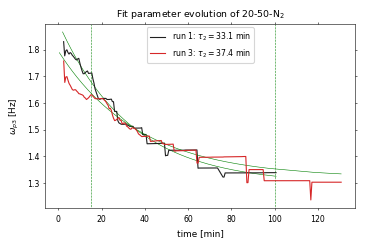

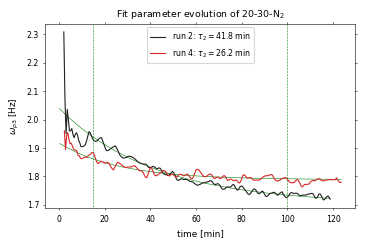

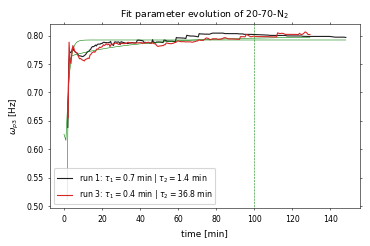

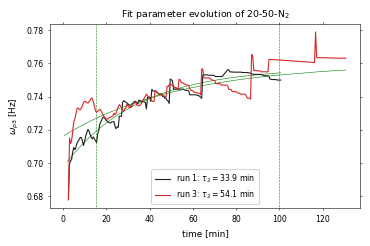

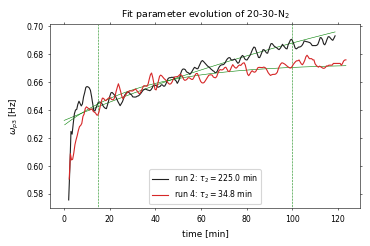

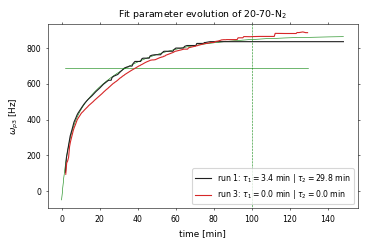

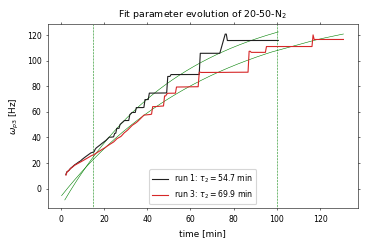

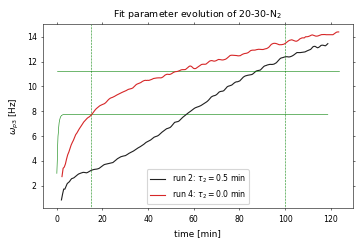

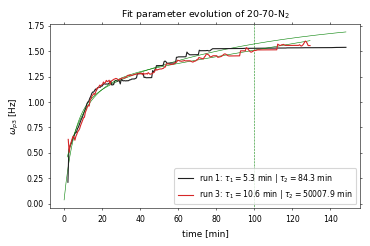

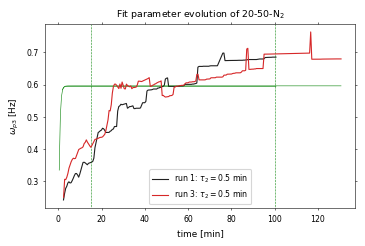

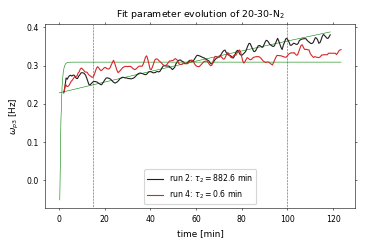

In [8]:
### parameters by temperature in N2

title_text = "Fit parameter evolution of " + SAMPLE_SHORT +"-"

def exp(x, a, b, c) :
    return a * np.exp(-x/b) + c
def exp2(x, a, b, c, d, e) :
    return a * np.exp(-x/b) + c + e * np.exp(-x/d) 

look_at = [0, 1, 2, 3]

for i in look_at :

    for temperature in TEMPS :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if id[3] != "N" or id[0] != temp[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            title_id = id[:-2]
            label = "run " + id[-1]
            t, p = DT_ALL[j][:], P_ALL[j][i][:]
            cutoff = 100
            pltt = t > 2
            
            if temperature != 70 :
                fitf = exp
                start = 15
                fitt2 = (t > start) & (t < cutoff)
                try :
                    popt2, _ = curve_fit(fitf, t[fitt2], p[fitt2], bounds=((-i_, 0., 0.), (i_, i_, i_)))
                    label += f': $\\tau_2 = ${np.round(popt2[1],1)} min'

                    y2 = fitf(t, *popt2)
                    plt.plot(t, y2, linewidth=0.5, color='g')
                except Exception as err :
                    print(str(type(err))[8:-2], ": ", err)

                plt.axvline(start, linestyle=':', color='g')
                plt.axvline(cutoff, linestyle=':', color='g')

            else :
                fitf = exp2
                fitt = t < cutoff
                try :
                    popt, _ = curve_fit(fitf, t[fitt], p[fitt], bounds=((-i_, 0., 0., 0., -i_), (i_, i_, i_, i_, i_)))
                    tau1 = np.round(min(popt[1], popt[3]),1)
                    tau2 = np.round(max(popt[1], popt[3]),1)
                    label += f': $\\tau_1 = ${tau1} min | $\\tau_2 = ${tau2} min'

                    y = fitf(t, *popt)
                    plt.plot(t, y, linewidth=0.5, color='g')
                except Exception as err :
                    print(str(type(err))[8:-2], ": ", err)

                plt.axvline(cutoff, linestyle=':', color='g')
            plt.plot(t[pltt], p[pltt], label=label, linewidth=1)
        
        plt.title(title_text + title_id)
        plt.xlabel("time [min]")
        plt.ylabel(parameter)
        plt.legend()
        #plt.savefig("results20/omegaevo/"+gas+" "+temp+".png", bbox_inches='tight')
        plt.show()

70
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.
70
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.


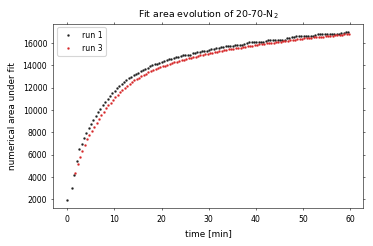

50
RuntimeError :  Optimal parameters not found: The maximum number of function evaluations is exceeded.
50
[-14877.23887085    744.25526381  32918.5474737     745.85744575
 -15924.9011493 ]


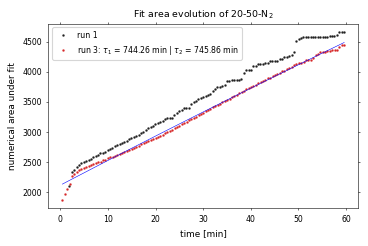

30
[-1.85268488e+03  1.69739679e+01  2.96900480e-09  6.95113282e+02
  6.80949548e+03]
30
[-3.37860718e+02  1.37035790e+00  2.09326616e+06  3.45304324e+05
 -2.09123222e+06]
30
[-3.26155576e+02  1.89954964e+01  2.61440813e+03  2.34169904e+00
 -4.85887132e+02]


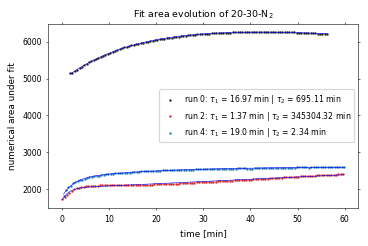

70
[ 5.79602243e+03  2.96114815e+02  3.31905598e-06  1.89439323e+02
 -3.84874251e+03]
70
[8.22956092e+01 6.48593830e+01 1.85642452e+03 8.77314447e-01
 3.25955232e+03]


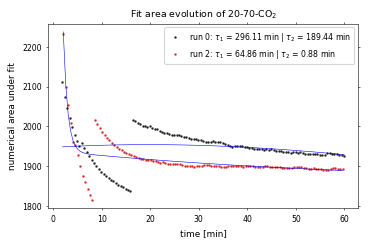

50
[6.21726536e+02 4.71561309e+00 1.33071778e+03 3.80244345e-01
 1.42463068e+03]


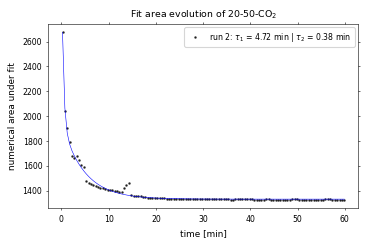

30
[ 321.28843285    3.30774494 1368.83218756   23.10431969  249.3920238 ]
30
[  43.53509698   66.69400322 1303.56541385    4.57159288  135.93278017]


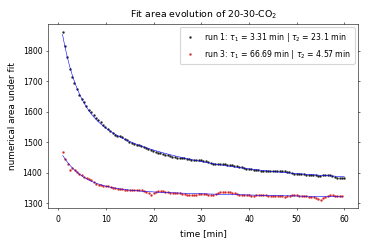

In [9]:
### Plot area

title_text = "Fit area evolution of " + SAMPLE_SHORT +"-"

p01 = [[3.13982775e+02, 3.54885096e+01, 1.81290828e+04, 5.70343000e+00, 5.24520412e+01],
    [1.18472451e+01, 1.11436920e+00, 1.98973972e+05, 6.78821372e+01, 7.78590720e+02],
    [1.50365926e+01, 2.43106947e+00, 2.61572150e+03, 1.94785320e+01, 1.12435019e+02]]
p02 = [[  13.43631687,    2.49961102, 1912.34579601,   15.56716046,   86.67703241],
    [2.47479126e+00, 3.42108290e-01, 1.32737618e+03, 5.26595996e+00, 3.37606163e+01],
    [  94.96847939,   16.59200303, 1383.53486793,    1.82029623,  10.93245541]]

for gas in GASES :
    for T_i, temperature in enumerate(TEMPS) :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if not (id[3] == gas[0] and id[0] == temp[0]) :#or (id[0]=='3' and id[-1]=='0') :
                continue
            label = "run " + id[-1]
            print (temp)
            t, a = DT_ALL[j], A_ALL[j]
            fitt = t < 60
            t, a = t[fitt], a[fitt]


            if id[3] == "N" :
                fitf = exp2
                p0 = p01[T_i]
            else :
                fitf = exp2
                p0 = p02[T_i]
            try :
                popt, _ = curve_fit(fitf, t, a, p0=p0, bounds=((-i_, 0, 0., 0, -i_), (i_, i_, i_, i_, i_)))
                print(popt)
                plt.plot(t, fitf(t, *popt), color="b")

                tau1 = np.round(popt[1],2)
                tau2 = np.round(popt[3],2)
                label = label + f': $\\tau_1$ = {tau1} min | $\\tau_2$ = {tau2} min'

                y1 = fitf(t, -i_, *popt[1:])
                y2 = fitf(t, *popt[:-1], -i_)
                #plt.plot(t, y1, linewidth=1, color='b', ls=":")
                #plt.plot(t, y2, linewidth=1, color='g', ls=":")
            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.scatter(t, a, label=label, linewidth=0.1)
            plt.title(title_text + id[:-2])

        plt.xlabel("time [min]")
        plt.ylabel("numerical area under fit")
        plt.legend()
        #plt.savefig("results20/areaevo/"+gas+" "+temp+"2.png", bbox_inches='tight')
        plt.show()

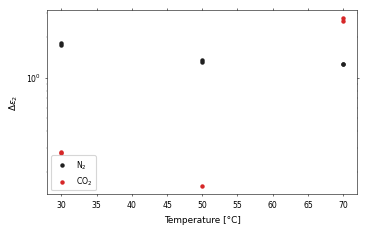

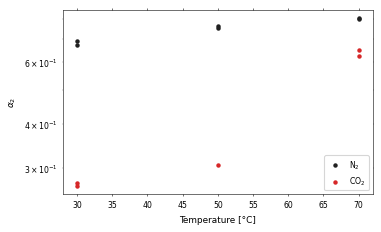

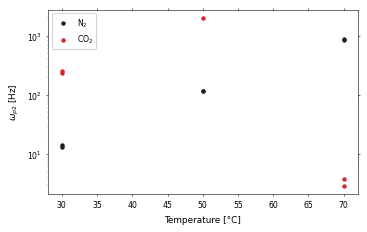

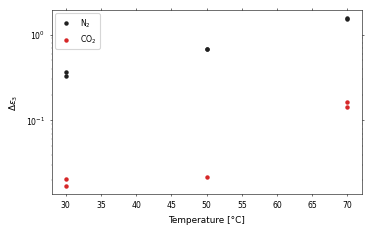

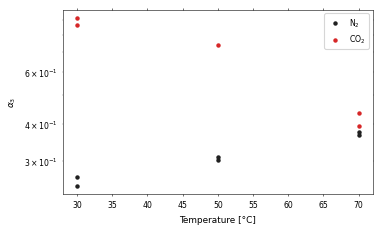

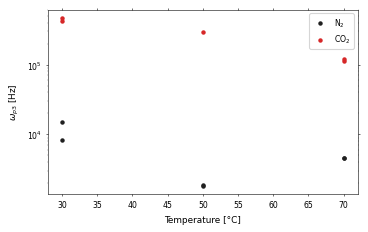

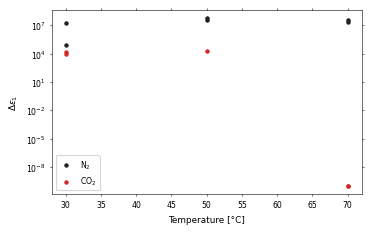

In [10]:
### plot final fit parameters against temperature

look_at = range(0,7)

for p in look_at :
    plt.yscale('log')

    for gas in GASES :
        values = []
        for j, id in enumerate(ID) :
            if not id[3] == gas[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            x = P_ALL_[j][p][-20:]
            xa = np.average(x)
            xe1 = xa - np.min(x)
            xe2 = np.max(x) - xa
            xe1 = xe1 * (xe1 > 0)
            xe2 = xe2 * (xe2 > 0)
            values.append(np.array([int(id[:2]), xa, xe1, xe2]))
        v = np.swapaxes(values, 0, 1)

        plt.scatter(v[0], v[1], linewidths=2, label=gas)
        #plt.errorbar(v[0], v[1], yerr=v[2:], fmt='none')

    plt.xlabel("Temperature [°C]")
    plt.ylabel(p_labels[p])
    plt.legend()
    plt.show()
